# Прогнозирование уровня средней заработной платы в России

Известны данные о заработной плате за каждый месяц с января 1993 по август 2016. Необходимо проанализировать данные, подобрать для них оптимальную прогнозирующую модель в классе ARIMA и построить прогноз на каждый месяц на два года вперёд от конца данных.

In [1]:
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [9]:
df = pd.read_csv('F:\\Work\\My\\Python\\courses\\courserra\\ml-specialization\\materials\\course5\\week1\\WAG_C_M.csv',
                 ';', 
                 index_col=['month'], 
                 parse_dates=['month'], 
                 dayfirst=True)

df.head()

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


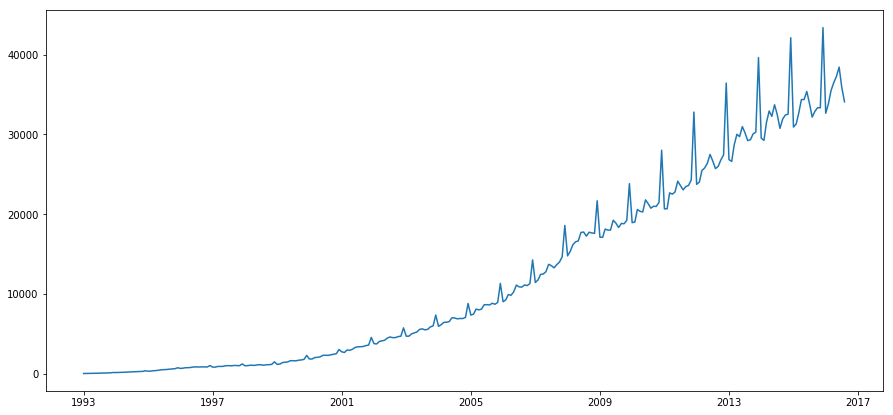

In [11]:
plt.figure(figsize(15,7))
plt.plot(df.index, df['WAG_C_M'])
plt.show()

Проверка стационарности и STL-декомпозиция ряда:

Критерий Дики-Фуллера: p=0.991850


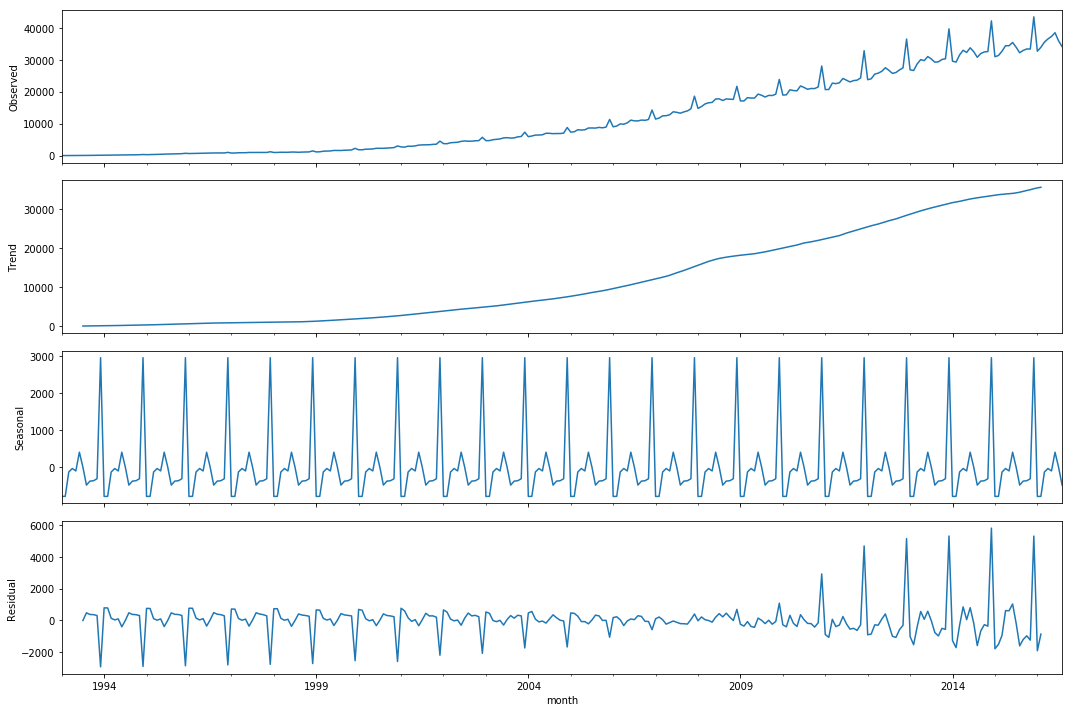

In [12]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(df['WAG_C_M']).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df['WAG_C_M'])[1])

### Стабилизация дисперсии

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


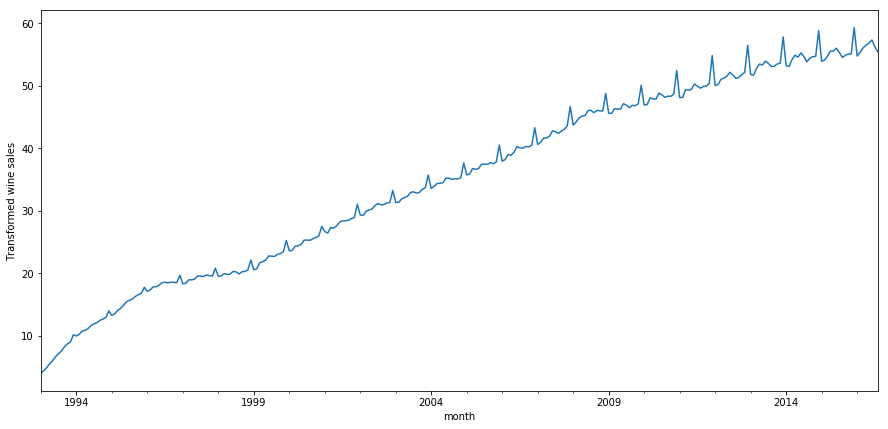

In [13]:
df['WAG_C_M_box'], lmbda = stats.boxcox(df['WAG_C_M'])
plt.figure(figsize(15,7))
df['WAG_C_M_box'].plot()
plt.ylabel(u'Transformed wages')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df['WAG_C_M_box'])[1])

### Стационарность

Критерий Дики-Фуллера отвергает гипотезу нестационарности, но визуально в данных виден тренд. Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

Критерий Дики-Фуллера: p=0.014697


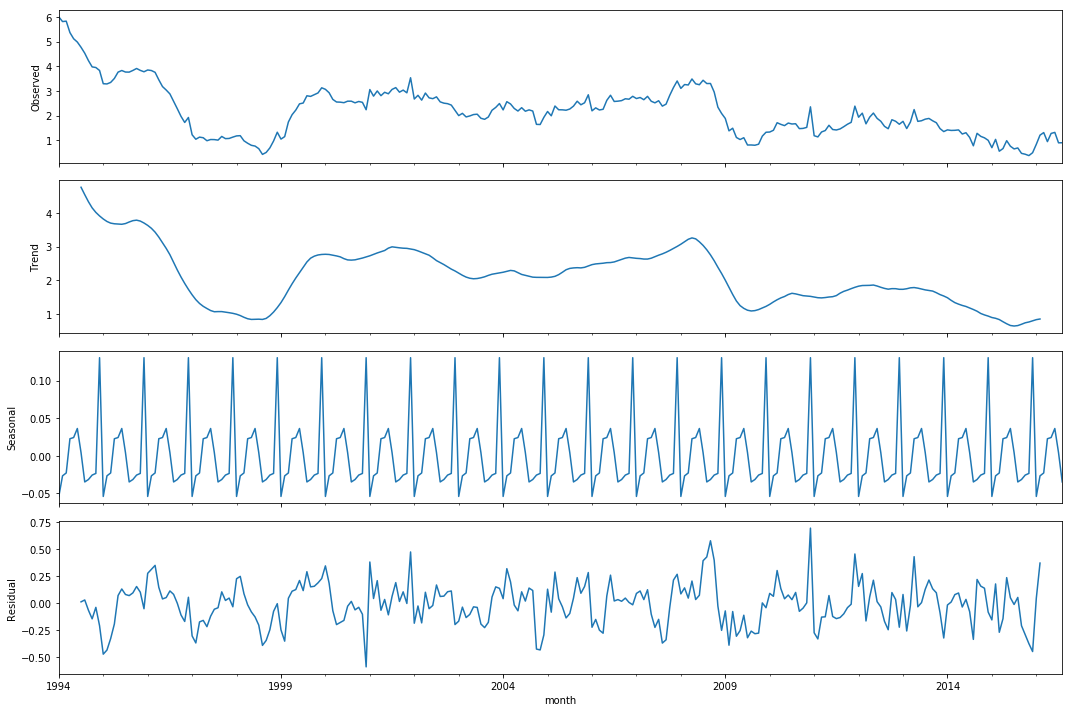

In [14]:
df['WAG_C_M_box_diff'] = df['WAG_C_M_box'] - df['WAG_C_M_box'].shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(df['WAG_C_M_box_diff'][12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df['WAG_C_M_box_diff'][12:])[1])

Критерий Дики-Фуллера отвергает гипотезу нестационарности, но полностью избавиться от тренда не удалось. Добавим обычное дифференцирование:

Критерий Дики-Фуллера: p=0.000000


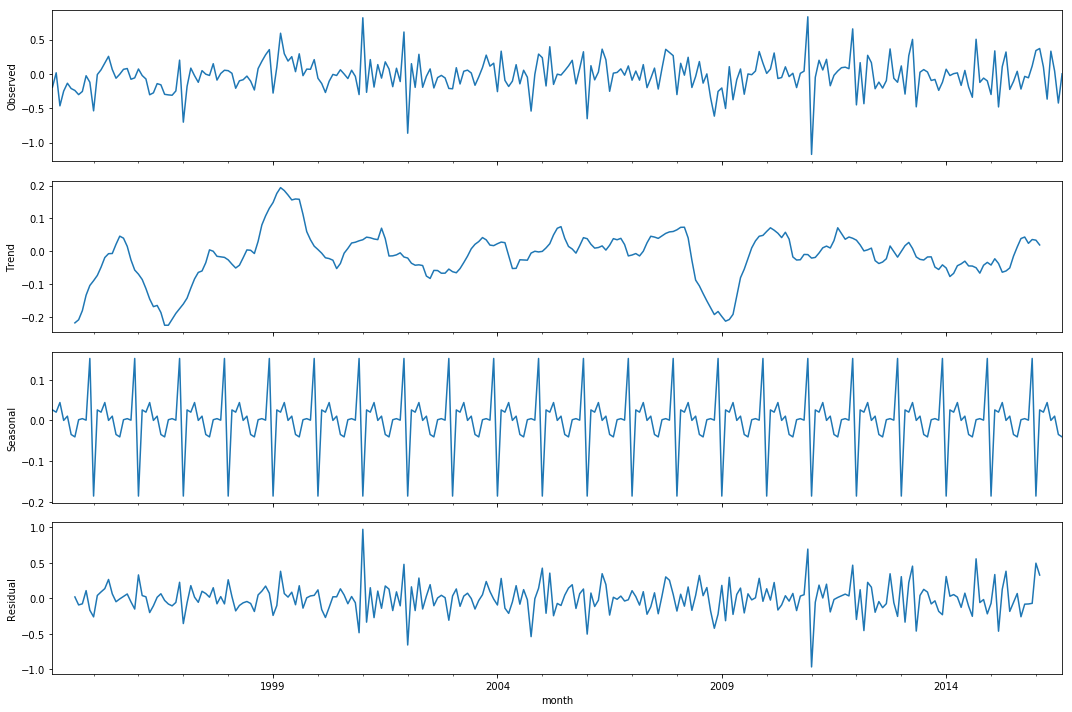

In [15]:
df['WAG_C_M_box_diff2'] = df['WAG_C_M_box_diff'] - df['WAG_C_M_box_diff'].shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(df['WAG_C_M_box_diff2'][13:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df['WAG_C_M_box_diff2'][13:])[1])

Гипотеза нестационарности уверенно отвергается, и визуально ряд выглядит лучше — тренда больше нет. 

## Подбор модели

Посмотрим на ACF и PACF полученного ряда:

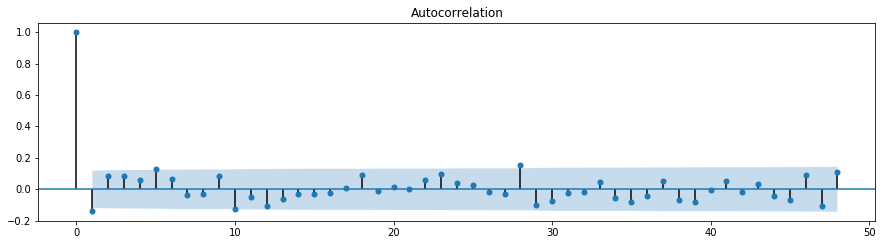

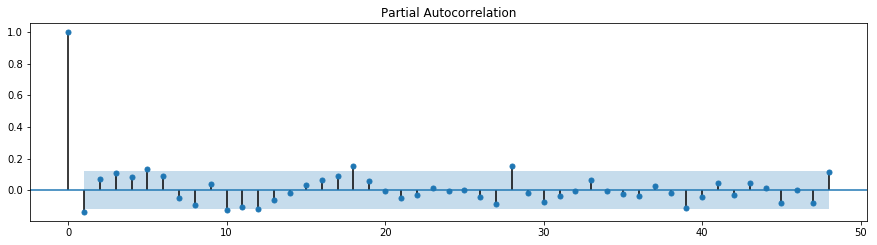

In [16]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df['WAG_C_M_box_diff2'][13:].values.squeeze(), lags=48, ax=ax)
plt.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df['WAG_C_M_box_diff2'][13:].values.squeeze(), lags=48, ax=ax)
plt.show()

Начальные приближения: Q=0, q=1, P=1, p=10

In [18]:
ps = range(0, 11)
d=1
qs = range(0, 2)
Ps = range(0, 2)
D=1
Qs = range(0, 1)

In [19]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

44

In [20]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(df['WAG_C_M_box'], order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

wrong parameters: (0, 0, 0, 0)
wrong parameters: (2, 1, 0, 0)
wrong parameters: (2, 1, 1, 0)
Wall time: 16.7 s


Если в предыдущей ячейке возникает ошибка, убедитесь, что обновили statsmodels до версии не меньше 0.8.0rc1.

In [23]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

       parameters       aic
22   (6, 0, 1, 0) -7.552970
40  (10, 1, 1, 0) -7.168053
39  (10, 1, 0, 0) -5.958381
26   (7, 0, 1, 0) -5.553215
24   (6, 1, 1, 0) -5.553081


Лучшая модель:

In [24]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                        WAG_C_M_box   No. Observations:                  284
Model:             SARIMAX(6, 1, 0)x(1, 1, 0, 12)   Log Likelihood                  11.776
Date:                            Fri, 03 Aug 2018   AIC                             -7.553
Time:                                    14:46:16   BIC                             21.639
Sample:                                01-01-1993   HQIC                             4.151
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1991      0.045     -4.401      0.000      -0.288      -0.110
ar.L2          0.0224      0.066   

Её остатки:

Критерий Стьюдента: p=0.293151
Критерий Дики-Фуллера: p=0.000000


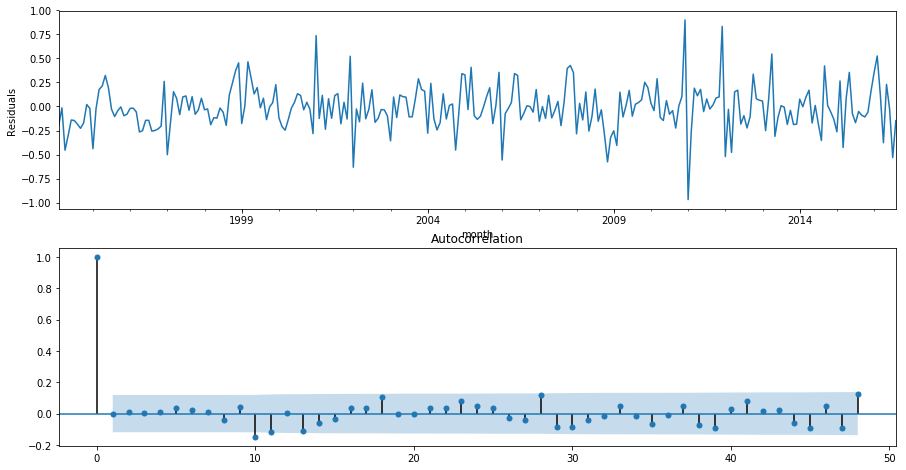

In [25]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).
Посмотрим, насколько хорошо модель описывает данные:

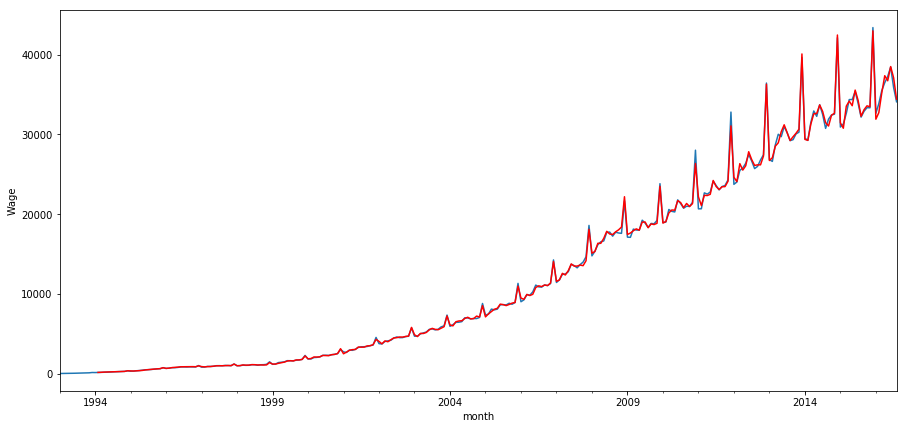

In [26]:
df['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
df['WAG_C_M'].plot()
df['model'] [13:].plot(color='r')
plt.ylabel('Wage')
plt.show()

### Прогноз

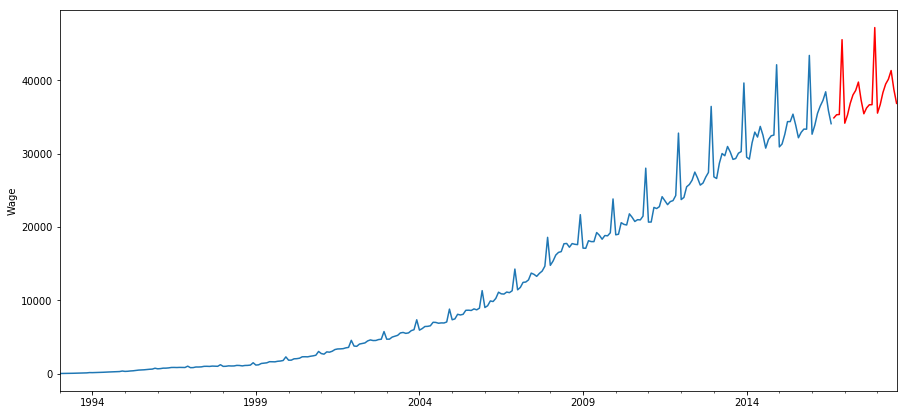

In [30]:
df2 = df[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,24)]
future = pd.DataFrame(index=date_list, columns= df2.columns)
df2 = pd.concat([df2, future])
df2['forecast'] = invboxcox(best_model.predict(start=284, end=307), lmbda)

plt.figure(figsize(15,7))
df2['WAG_C_M'].plot()
df2['forecast'].plot(color='r')
plt.ylabel('Wage')
plt.show()